# Behavioral segmentation: RFM model
- Recency — number of days since the last purchase
- Frequency — number of transactions made over a given period
- Monetary — amount spent over a given period of time

In [40]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.templates.default = "seaborn"

Read data & convert data type:

In [2]:
df_all = pd.read_csv("combined_data.csv")
df_all

,Unnamed: 0,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,weekday,...,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,first_order_date,usertype,no_of_items,price,freight_value
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,Mon,...,38.71,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,São Paulo,2017-09-04 11:26:38,Return,1.0,29.99,8.72
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,Tue,...,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,Bahia,2018-07-24 20:41:37,New,1.0,118.70,22.76
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,Wed,...,179.12,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,Goiás,2018-08-08 08:38:49,New,1.0,159.90,19.22
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,Sat,...,72.20,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,Rio Grande do Norte,2017-11-18 19:28:06,New,1.0,45.00,27.20
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,Tue,...,28.62,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,São Paulo,2018-02-13 21:18:39,New,1.0,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99086,99086,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,Thu,...,85.08,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,São Paulo,2017-03-09 09:54:05,New,1.0,72.00,13.08
99087,99087,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,Tue,...,195.00,da62f9e57a76d978d02ab5362c509660,11722,praia grande,São Paulo,2018-02-06 12:58:58,New,1.0,174.90,20.10
99088,99088,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,Sun,...,271.01,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,Bahia,2017-08-27 14:46:43,New,1.0,205.99,65.02
99089,99089,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,Mon,...,441.16,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,Rio de Janeiro,2018-01-08 21:28:27,New,2.0,359.98,81.18


In [3]:
df_all["order_purchase_timestamp"] = pd.to_datetime(df_all["order_purchase_timestamp"])
df_all["order_approved_at"] = pd.to_datetime(df_all["order_approved_at"])
df_all["order_delivered_carrier_date"] = pd.to_datetime(df_all["order_delivered_carrier_date"])
df_all["order_delivered_customer_date"] = pd.to_datetime(df_all["order_delivered_customer_date"])
df_all["order_estimated_delivery_date"] = pd.to_datetime(df_all["order_estimated_delivery_date"])

## 1. Manually assign labels based on distribution
Create a snapshot date for calculating recency

In [4]:
snapshot_date = df_all['order_purchase_timestamp'].max() + timedelta(days=1)
print(snapshot_date)

2018-08-31 15:11:58


In [5]:
data_process = df_all.groupby(['customer_unique_id']).agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'count',
    'payment_value': 'sum'})

In [6]:
data_process.rename(columns={'order_purchase_timestamp': 'Recency',
                             'order_id': 'Frequency',
                             'payment_value': 'Monetary'}, inplace=True)
data_process

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19
0000f46a3911fa3c0805444483337064,538,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
0004aac84e0df4da2b147fca70cf8255,289,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58
ffff371b4d645b6ecea244b27531430a,569,1,112.46


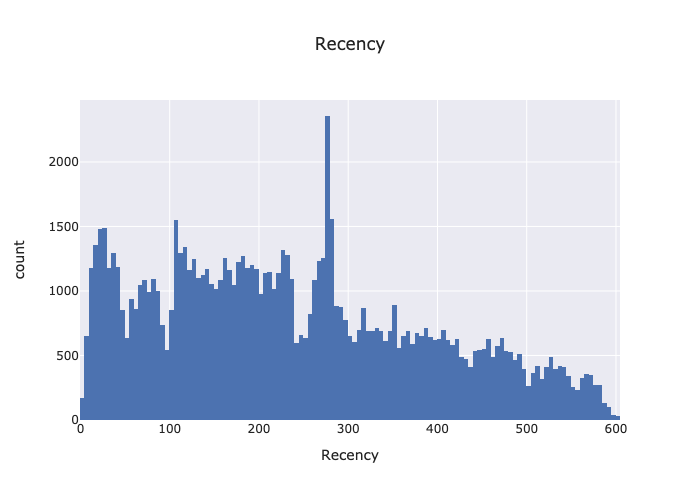

In [41]:
fig = px.histogram(data_process, x="Recency",
                   title='Recency')
#fig.show()
fig.show(renderer="png")

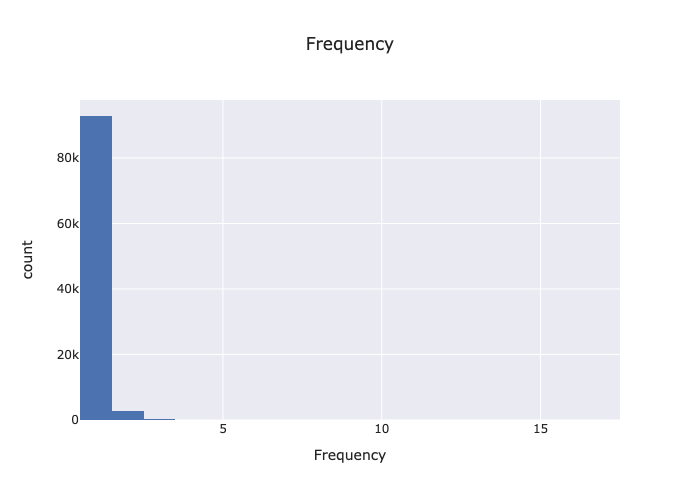

In [42]:
fig = px.histogram(data_process, x="Frequency",
                   title='Frequency')
#fig.show()
fig.show(renderer="png")

In [9]:
data_process.groupby(["Frequency"]).count()

,Recency,Monetary
Frequency,,
1,92798,92798
2,2728,2728
3,198,198
4,30,30
5,8,8
6,6,6
7,3,3
9,1,1
17,1,1


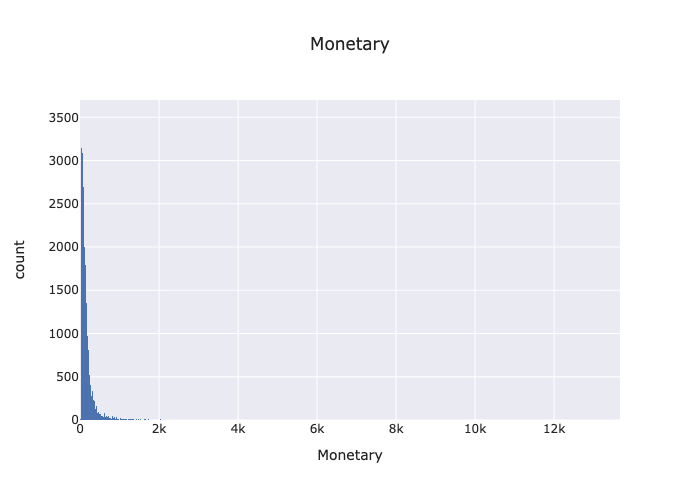

In [43]:
fig = px.histogram(data_process, x="Monetary",
                   title='Monetary')
#fig.show()
fig.show(renderer="png")

### Calculate R and F groups

#### Recency: 5 labels for 5 equal percentile groups

5 is the highest recency, 1 is lowest

In [11]:
r_labels = range(5, 0, -1)
r_groups = pd.qcut(data_process['Recency'], [0, 0.2, 0.4, 0.6, 0.8, 1], labels=r_labels)
data_process = data_process.assign(R = r_groups.values)

#### Frequency: 3 groups, not evenly distributed

- 1: just once
- 2: 2-6 times
- 3: more than 7 times

In [12]:
data_process['F'] = 1
data_process.loc[(data_process['Frequency'] >= 2) & (data_process['Frequency'] < 7), 'F'] = 2
data_process.loc[data_process['Frequency'] >= 7, 'F'] = 3

#### Monetary: 5 labels for 5 equal percentile groups

1 is lowest spending, 5 is highest

In [13]:
m_labels = range(1, 6)
m_groups = pd.qcut(data_process['Monetary'], [0, 0.2, 0.4, 0.6, 0.8, 1], labels=m_labels)
data_process = data_process.assign(M = m_groups.values)

In [14]:
def join_rfm(x):
    return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))

data_process['RFM_Segment'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,4,1,1,411
0000f46a3911fa3c0805444483337064,538,1,86.22,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,1,4,214


**In theory, the highest score is 5+3+5 = 13, the lowest score is 1+1+1 = 1**

In [15]:
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

### Add segment label and actions

In [16]:
def rfm_level(df):
    if df['RFM_Score'] >= 11:
        return 'VIP - Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 9) and (df['RFM_Score'] < 11)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Potential Loyalist'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 8)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 6)):
        return 'Needs Attention'
    else:
        return 'Hibernating - Almost Lost'

rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,4,1,4,414,9,Champions
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,4,1,1,411,6,Promising
0000f46a3911fa3c0805444483337064,538,1,86.22,1,1,2,112,4,Needs Attention
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,1,1,211,4,Needs Attention
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,1,4,214,7,Promising
...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,2067.42,1,1,5,115,7,Promising
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58,3,1,2,312,6,Promising
ffff371b4d645b6ecea244b27531430a,569,1,112.46,1,1,3,113,5,Needs Attention


In [17]:
def rfm_action(df):
    if df['RFM_Score'] >= 11:
        return 'Exclusive offer & referral program'
    elif ((df['RFM_Score'] >= 9) and (df['RFM_Score'] < 11)):
        return 'Upsell & Cross-sell'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Cross-sell & price incentives'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 8)):
        return 'Price incentives & limited time offer'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 6)):
        return 'Aggressive price incentives'
    else:
        return 'No need to re-acquire'

rfm['RFM_Action'] = rfm.apply(rfm_action, axis=1)
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,RFM_Action
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,4,1,4,414,9,Champions,Upsell & Cross-sell
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,4,1,1,411,6,Promising,Price incentives & limited time offer
0000f46a3911fa3c0805444483337064,538,1,86.22,1,1,2,112,4,Needs Attention,Aggressive price incentives
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,1,1,211,4,Needs Attention,Aggressive price incentives
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,1,4,214,7,Promising,Price incentives & limited time offer
...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,2067.42,1,1,5,115,7,Promising,Price incentives & limited time offer
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58,3,1,2,312,6,Promising,Price incentives & limited time offer
ffff371b4d645b6ecea244b27531430a,569,1,112.46,1,1,3,113,5,Needs Attention,Aggressive price incentives


### Visualization

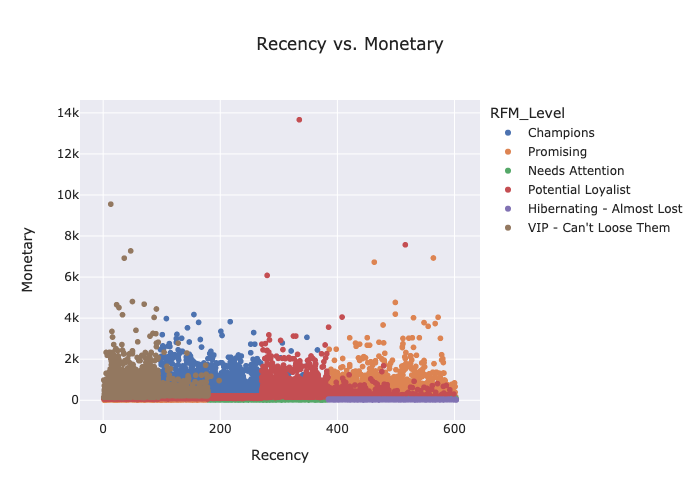

In [44]:
fig = px.scatter(rfm, x="Recency", y="Monetary",
                 color='RFM_Level',
                 hover_data={'RFM_Level':True},
                 title='Recency vs. Monetary')
#fig.show()
fig.show(renderer="png")
#fig.write_html("visuals/Recency vs. Monetary.html")

Calculate average values for each RFM_Level, and return a size of each segment

In [19]:
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2).reset_index()
# Print the aggregated dataset
rfm_level_agg

RFM_Level Recency Frequency Monetary       
                                mean      mean     mean  count
0                  Champions  121.80      1.06   258.45  19542
1  Hibernating - Almost Lost  475.42      1.00    39.72   3969
2            Needs Attention  359.21      1.00    65.98  19440
3         Potential Loyalist  185.50      1.03   199.93  15321
4                  Promising  258.86      1.01   133.14  33084
5     VIP - Can't Loose Them   55.34      1.25   449.59   4417

In [20]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RFM_Level', 'RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_level_agg

,RFM_Level,RecencyMean,FrequencyMean,MonetaryMean,Count
0,Champions,121.80,1.06,258.45,19542
1,Hibernating - Almost Lost,475.42,1.00,39.72,3969
2,Needs Attention,359.21,1.00,65.98,19440
3,Potential Loyalist,185.50,1.03,199.93,15321
4,Promising,258.86,1.01,133.14,33084
5,VIP - Can't Loose Them,55.34,1.25,449.59,4417


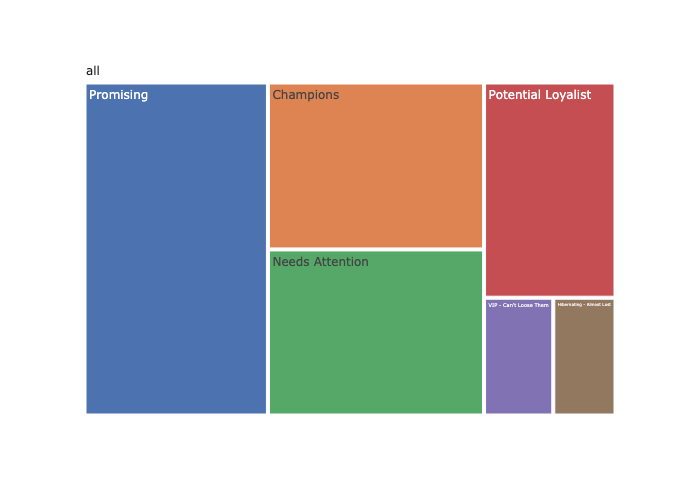

In [45]:
fig = px.treemap(rfm_level_agg, path=[px.Constant("all"), 'RFM_Level'], values='Count')
#fig.show()
fig.show(renderer="png")

## 2. K-means

The goal of K means is to group data points into distinct non-overlapping subgroups. K-Means clustering is unsupervised: no labeled data for this clustering; It performs the division of objects into clusters that share similarities and are dissimilar to the objects belonging to another cluster.

In [22]:
data_rfm = rfm[['Recency', 'Frequency', 'Monetary']]

In [23]:
data_rfm

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19
0000f46a3911fa3c0805444483337064,538,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
0004aac84e0df4da2b147fca70cf8255,289,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58
ffff371b4d645b6ecea244b27531430a,569,1,112.46


To find which ‘k’ value is more suitable for our data, we use **the elbow method**:

- Compute K-Means clustering for different values of K by varying K from 1 to 10 clusters.
- For each K, calculate the total within-cluster sum of square (WCSS).
- Plot the curve of WCSS vs the number of clusters K.
- The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters.

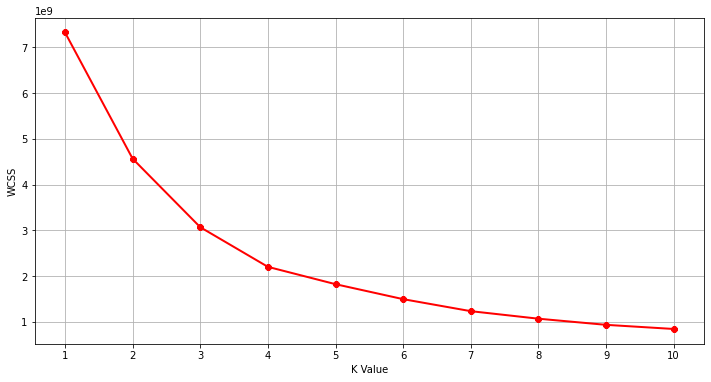

In [24]:
from sklearn.cluster import KMeans

wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(data_rfm)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [25]:
kmeans = KMeans(n_clusters = 4) 
kmeans.fit(data_rfm)

cluster_labels = kmeans.labels_
data_rfm_k4 = data_rfm.assign(Cluster = cluster_labels)
grouped = data_rfm_k4.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(2)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0        128.68      1.03   121.25  50751
1        387.04      1.02   121.21  38226
2        230.76      1.13   620.79   6080
3        239.80      1.09  1931.78    716

Since the elbow is not clear on the curve, we calculate the **silhouette score**:

- 1: Means clusters are well apart from each other and clearly distinguished.
- 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
- -1: Means clusters are assigned in the wrong way.

In [26]:
from sklearn.metrics import silhouette_score
%matplotlib inline

print(f'Silhouette Score(k=4): {silhouette_score(data_rfm, cluster_labels)}')

Silhouette Score(k=4): 0.4563935842651788


In [27]:
kmeans = KMeans(n_clusters = 5) 
kmeans.fit(data_rfm)

cluster_labels = kmeans.labels_
data_rfm_k5 = data_rfm.assign(Cluster = cluster_labels)
grouped = data_rfm_k5.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(2)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0        128.75      1.02   107.91  47900
1        221.25      1.11   404.02   9660
2        232.96      1.10  2487.54    325
3        391.25      1.02   110.26  35818
4        244.84      1.14  1021.71   2070

In [28]:
print(f'Silhouette Score(k=5): {silhouette_score(data_rfm, cluster_labels)}')

Silhouette Score(k=5): 0.4605425086496772


In [29]:
kmeans = KMeans(n_clusters = 6) 
kmeans.fit(data_rfm)

cluster_labels = kmeans.labels_
data_rfm_k6 = data_rfm.assign(Cluster = cluster_labels)
grouped = data_rfm_k6.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(2)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0        255.04      1.02   110.36  32726
1        269.69      1.12  3660.77     89
2         87.33      1.03   118.45  33069
3        456.71      1.02   119.85  21103
4        226.03      1.12   509.28   7571
5        241.30      1.12  1403.12   1215

In [30]:
print(f'Silhouette Score(k=6): {silhouette_score(data_rfm, cluster_labels)}')

Silhouette Score(k=6): 0.3893520040506839


Therefore, 5 segments would be optimized

In [31]:
data_rfm_k5

,Recency,Frequency,Monetary,Cluster
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,0
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,0
0000f46a3911fa3c0805444483337064,538,1,86.22,3
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,3
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,3
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,2067.42,2
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58,3
ffff371b4d645b6ecea244b27531430a,569,1,112.46,3


In [47]:
data_rfm_k5["Cluster"] = data_rfm_k5["Cluster"].astype("string")

Based on the distribution pattern above, we can assign labels to each cluster for better description.

In [55]:
def rfm_level(df):
    if df['Cluster'] == "0": #low recency, low monetary, low to mid frequency
        return 'Promising'
    elif (df['Cluster'] == "1"): #high monetary
        return 'VIP'
    elif (df['Cluster'] == "2"): #low to mid monetary
        return 'Potential Loyalist'
    elif (df['Cluster'] == "3"): #mid to high monetary
        return 'Champions'
    else: #high recency, low monetary, low to mid frequency
        return 'Hibernating'

data_rfm_k5['RFM_Level'] = data_rfm_k5.apply(rfm_level, axis=1)
data_rfm_k5

,Recency,Frequency,Monetary,Cluster,RFM_Level,RFM_Action
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,0,Promising,Aggressive price incentives
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,0,Promising,Aggressive price incentives
0000f46a3911fa3c0805444483337064,538,1,86.22,3,Champions,Upsell & Cross-sell
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,3,Champions,Upsell & Cross-sell
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,3,Champions,Upsell & Cross-sell
...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,2067.42,2,Potential Loyalist,Price incentives & limited time offer
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58,3,Champions,Upsell & Cross-sell
ffff371b4d645b6ecea244b27531430a,569,1,112.46,3,Champions,Upsell & Cross-sell


In [52]:
def rfm_action(df):
    if df['Cluster'] == "0": #low recency, low monetary, low to mid frequency
        return 'Aggressive price incentives'
    elif (df['Cluster'] == "1"): #high monetary
        return 'Exclusive offer & referral program'
    elif (df['Cluster'] == "2"): #low to mid monetary
        return 'Price incentives & limited time offer'
    elif (df['Cluster'] == "3"): #mid to high monetary
        return 'Upsell & Cross-sell'
    else: #high recency, low monetary, low to mid frequency
        return 'No need to re-acquire'

data_rfm_k5['RFM_Action'] = data_rfm_k5.apply(rfm_action, axis=1)
data_rfm_k5

,Recency,Frequency,Monetary,Cluster,RFM_Level,RFM_Action
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,0,Promising,Aggressive price incentives
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,0,Promising,Aggressive price incentives
0000f46a3911fa3c0805444483337064,538,1,86.22,3,Champions,Upsell & Cross-sell
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,3,Champions,Upsell & Cross-sell
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,3,Champions,Upsell & Cross-sell
...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,2067.42,2,Potential Loyalist,Price incentives & limited time offer
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58,3,Champions,Upsell & Cross-sell
ffff371b4d645b6ecea244b27531430a,569,1,112.46,3,Champions,Upsell & Cross-sell


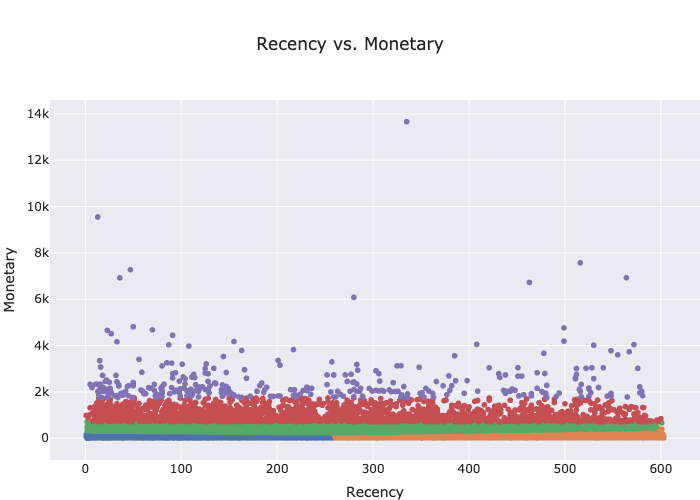

In [64]:
fig = px.scatter(data_rfm_k5, x="Recency", y="Monetary",
                 color='RFM_Level', height = 500,
                 hover_data={'RFM_Level':True, 'RFM_Action':True},
                 title='Recency vs. Monetary')

fig.update_layout(margin ={'l':50,'b':0,'r':0})
fig.update_layout(showlegend=False)

#fig.show()
fig.show(renderer="png")
fig.write_html("visuals/segment_recency_monetary.html")

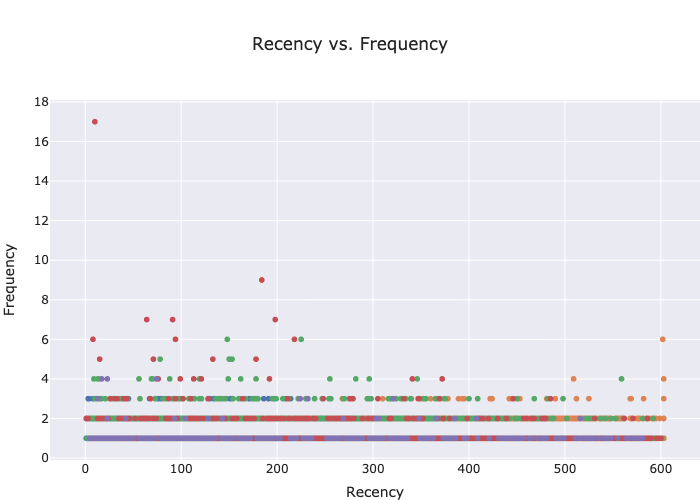

In [65]:
fig = px.scatter(data_rfm_k5, x="Recency", y="Frequency",
                 color='RFM_Level', height = 500,
                 hover_data={'RFM_Level':True, 'RFM_Action':True},
                 title='Recency vs. Frequency')

fig.update_layout(margin ={'l':50,'b':0,'r':0})
fig.update_layout(showlegend=False)

#fig.show()
fig.show(renderer="png")
fig.write_html("visuals/segment_recency_frequency.html")

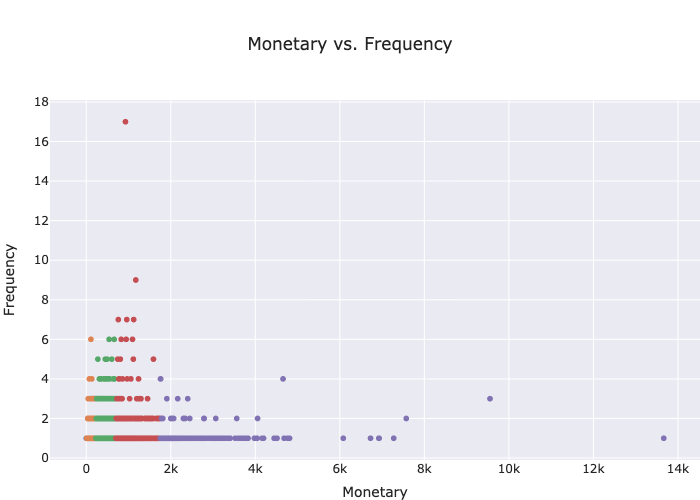

In [67]:
fig = px.scatter(data_rfm_k5, x="Monetary", y="Frequency",
                 color='RFM_Level', height = 500,
                 hover_data={'RFM_Level':True, 'RFM_Action':True},
                 title='Monetary vs. Frequency')

fig.update_layout(margin ={'l':50,'b':0,'r':0})
fig.update_layout(showlegend=False)

#fig.show()
fig.show(renderer="png")
fig.write_html("visuals/segment_monetary_frequency.html")

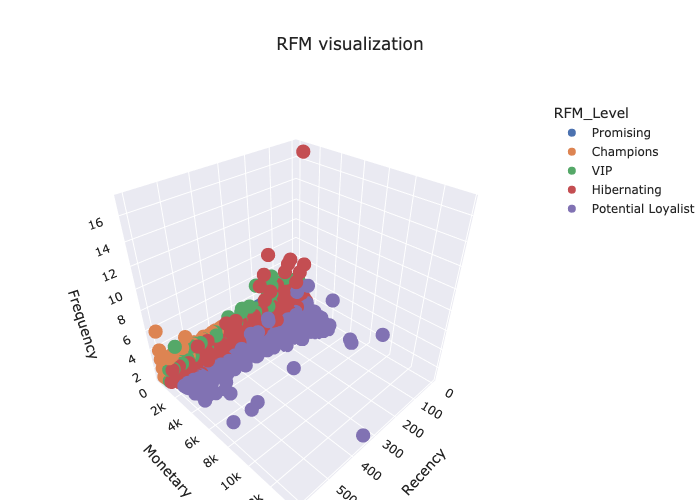

In [66]:
fig = px.scatter_3d(data_rfm_k5, x='Recency', y='Monetary', z='Frequency',
                    hover_data={'RFM_Level':True, 'RFM_Action':True},
                    height = 500, color='RFM_Level',
                    title = "RFM visualization")

fig.update_layout(margin ={'l':50,'b':0,'r':0})

#fig.show()
fig.show(renderer="png")
fig.write_html("visuals/3D-grid.html")

In [37]:
rfm_group = data_rfm_k5.groupby('RFM_Level')['Cluster'].count().round(2).reset_index()
rfm_group

,RFM_Level,Cluster
0,Champions,35818
1,Hibernating - Almost Lost,2070
2,Potential Loyalist,325
3,Promising,47900
4,VIP,9660


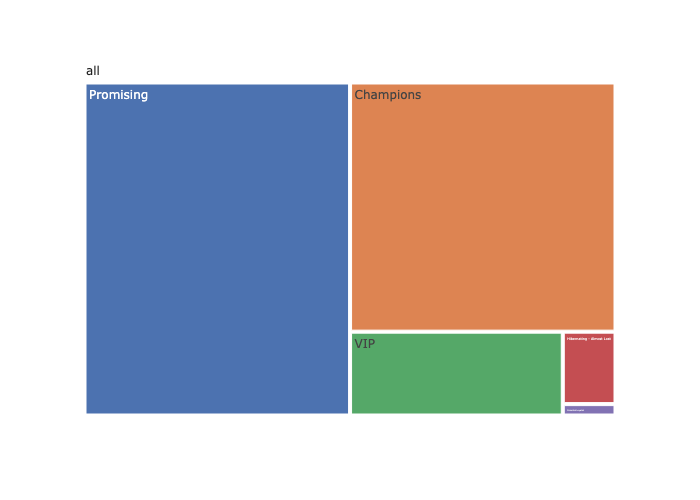

In [63]:
fig = px.treemap(rfm_group, path=[px.Constant("all"), 'RFM_Level'], values='Cluster')
#fig.show()
fig.show(renderer="png")
fig.write_html("visuals/tree-map.html")

In [39]:
data_rfm_k5.to_csv("segment_data.csv")